In [1]:
import numpy as np
from functions.propagators import TwoBody
import scipy as sp
from functions.read_ICs import read_ICs
from functions.dwell_times import hist_linear_density, altitude_blocks

# GTO from 100, 200, 500 km

prop = TwoBody(mu=3.986e5)
# set ICs
r0 = np.array([100, 200, 500, 1000, 10000, 25000]) + 6371
r1 = 6371 + 35786
sma = (r0 + r1) / 2
v0 = np.sqrt(2 * prop.mu / r0 - prop.mu / sma)
tf = 2 * np.pi * np.sqrt(sma**3 / prop.mu)
zro = 0*r0
ics = np.array(
    [
        r0,
        zro,
        zro,
        zro,
        v0,
        zro,
    ]
).T
ids = [100, 200, 500, 1000, 10000, 25000]
GTO_ICs = ics

states = []
times = []
for idx in range(len(ids)):
    prop.propagate(GTO_ICs[idx, :], tf[idx])
    states.append(prop.states)
    times.append(prop.ts)

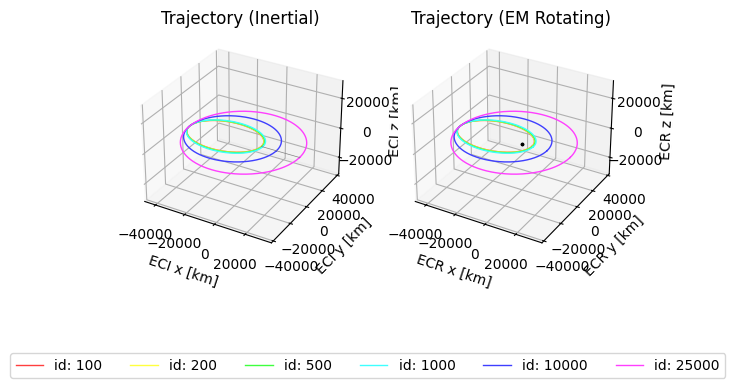

In [2]:
from functions.plot_trajectories import plot_trajectories

plot_trajectories(
    states,
    states,
    ics,
    [0, 0],
    ids,
)

# Case 1: MEO Linear

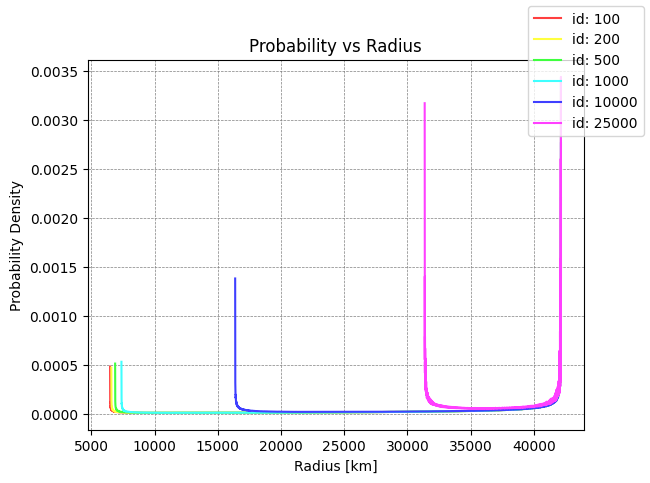

In [5]:
ps, alts = hist_linear_density(
    states,
    times,
    tf,
    0,
    ids,
)
alt_block = (20000 + 6371, 30000 + 6371)

pMEO_hist = []
for i in range(len(ids)):
    indices = (alts[i] >= alt_block[0]) * (alts[i] < alt_block[1])
    pMEO_hist.append(
        np.trapezoid(ps[i][indices], alts[i][indices])
    )
pMEO_altBlocks = altitude_blocks(
    states,
    times,
    tf,
    0,
    ids,
    {"LEO": alt_block},
)


In [6]:
pMEO_hist

[np.float64(0.25933395000000015),
 np.float64(0.2592095999999998),
 np.float64(0.2592892999999999),
 np.float64(0.25918925),
 np.float64(0.2774818499999999),
 np.float64(0.428538399999998)]

In [7]:
pMEO_altBlocks

[{'LEO': np.float64(0.2593107995777349)},
 {'LEO': np.float64(0.259226363977542)},
 {'LEO': np.float64(0.2592854447278316)},
 {'LEO': np.float64(0.25926247387833967)},
 {'LEO': np.float64(0.2775540811009411)},
 {'LEO': np.float64(0.43020343934419264)}]

# Case 2: MEO weighted by proximity to 12hr orbit
### Standard deviation of 3000 km (so Galileo is roughly 1sigma)

In [8]:
GPSalt = 26560
cluster_pdf = sp.stats.norm(loc=26560, scale=3000)
normal_pts = [cluster_pdf.pdf(alts_run) for alts_run in alts]
totProb = [normal_pts[i] * ps[i] for i in range(len(ids))]
pMEO_prod = []
for i in range(len(ids)):
    pMEO_prod.append(
        np.trapezoid(totProb[i], alts[i])
    )

In [9]:
pMEO_prod

[np.float64(2.002337908076415e-05),
 np.float64(2.0032297917220784e-05),
 np.float64(2.0062209656217194e-05),
 np.float64(2.011672136807404e-05),
 np.float64(2.3661667596893276e-05),
 np.float64(7.054541440578064e-06)]

# Ingest TLE data

In [10]:
from functions.tle_histogram import SMA_GMM
import sklearn.mixture

In [11]:
def eval_GMM_PDF(model: sklearn.mixture.GaussianMixture, x):
    means = model.means_.flatten()
    wts = model.weights_.flatten()
    covars = model.covariances_
    prob_densities = np.zeros_like(x)
    for n in range(len(means)):
        cluster_pdf = sp.stats.norm(loc=means[n], scale=np.sqrt(covars[n]))
        prob_densities += wts[n] * cluster_pdf.pdf(x).squeeze()
    return prob_densities

### GMM with 1 cluster

In [12]:
gmm_1 = SMA_GMM("data/tles.txt", 1)
gmm1_pdf = [eval_GMM_PDF(gmm_1, alts_run) for alts_run in alts]
gmm1_prob = [gmm1_pdf[i] * ps[i] for i in range(len(ids))]
pGMM1_prod = []
for i in range(len(ids)):
    pGMM1_prod.append(np.trapezoid(gmm1_prob[i], alts[i]))
pGMM1_prod

[np.float64(1.0691227200636324e-05),
 np.float64(1.0702991423647944e-05),
 np.float64(1.0735063305333758e-05),
 np.float64(1.0779936028893707e-05),
 np.float64(9.252629945538186e-06),
 np.float64(2.196961803025131e-06)]

### GMM with 2 clusters

In [13]:
gmm_2 = SMA_GMM("data/tles.txt", 2)
gmm2_pdf = [eval_GMM_PDF(gmm_2, alts_run) for alts_run in alts]
gmm2_prob = [gmm2_pdf[i] * ps[i] for i in range(len(ids))]
pGMM2_prod = []
for i in range(len(ids)):
    pGMM2_prod.append(np.trapezoid(gmm2_prob[i], alts[i]))
pGMM2_prod

[np.float64(2.0944596611182598e-05),
 np.float64(2.253553574921548e-05),
 np.float64(2.655721061681149e-05),
 np.float64(1.5593646678237792e-05),
 np.float64(3.74777253644376e-06),
 np.float64(3.884208504798099e-06)]

### GMM with 3 clusters

In [14]:
gmm_3 = SMA_GMM("data/tles.txt", 3)
gmm3_pdf = [eval_GMM_PDF(gmm_3, alts_run) for alts_run in alts]
gmm3_prob = [gmm3_pdf[i] * ps[i] for i in range(len(ids))]
pGMM3_prod = []
for i in range(len(ids)):
    pGMM3_prod.append(np.trapezoid(gmm3_prob[i], alts[i]))
pGMM3_prod

[np.float64(2.0711028442003756e-05),
 np.float64(2.2299666491634727e-05),
 np.float64(2.63007195952964e-05),
 np.float64(1.5395276939438535e-05),
 np.float64(3.549704618454325e-06),
 np.float64(2.9124442881143172e-06)]

### GMM with 4 clusters

In [15]:
gmm_4 = SMA_GMM("data/tles.txt", 4)
gmm4_pdf = [eval_GMM_PDF(gmm_4, alts_run) for alts_run in alts]
gmm4_prob = [gmm4_pdf[i] * ps[i] for i in range(len(ids))]
pGMM4_prod = []
for i in range(len(ids)):
    pGMM4_prod.append(np.trapezoid(gmm4_prob[i], alts[i]))
pGMM4_prod

[np.float64(2.5633087020707836e-05),
 np.float64(2.7076412039610347e-05),
 np.float64(3.1198905311905745e-05),
 np.float64(2.015301126677209e-05),
 np.float64(8.438354912569761e-06),
 np.float64(9.04031052367218e-06)]

### GMM with 5 clusters

In [16]:
gmm_5 = SMA_GMM("data/tles.txt", 5)
gmm5_pdf = [eval_GMM_PDF(gmm_5, alts_run) for alts_run in alts]
gmm5_prob = [gmm5_pdf[i] * ps[i] for i in range(len(ids))]
pGMM5_prod = []
for i in range(len(ids)):
    pGMM5_prod.append(np.trapezoid(gmm5_prob[i], alts[i]))
pGMM5_prod

[np.float64(2.5627692036844175e-05),
 np.float64(2.7071868994172406e-05),
 np.float64(3.119058276284492e-05),
 np.float64(2.015428392522003e-05),
 np.float64(8.43644125602446e-06),
 np.float64(9.007342028292384e-06)]